In [1]:
!git clone https://github.com/sehyunsix/NERF-vs-QRF.git

fatal: destination path 'NERF-vs-QRF' already exists and is not an empty directory.


In [2]:
%cd NERF-vs-QRF
!git pull origin colab
!git checkout colab
!pip install -r requirments.txt

/content/NERF-vs-QRF
From https://github.com/sehyunsix/NERF-vs-QRF
 * branch            colab      -> FETCH_HEAD
Already up to date.
Already on 'colab'
Your branch is up to date with 'origin/colab'.


In [3]:
%cd 2d-image



/content/NERF-vs-QRF/2d-image


In [ ]:
###
HEIGHT = 1400
WIDTH = 1050


###
EPOCH = 1
BATCH_SIZE = 128
LR = 1e-4

###
WIRE = 20
LAYER = 2
DEVICE = "cuda"

IMAGE_PATH = "test3.jpg"


METHOD = "quantum"
# METHOD = "mlp"
# METHOD = "mlp"  # Replace with the path to your image


In [4]:

import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from qrelu import QuantumReLU
from config import *


class sin_qml(nn.Module):
    def __init__(self, num_qubit, num_layer, use_qrelu):
        """
        nun_qubit(int) : 사용할 qubit 개수
        num_layer(int) : 총 layer의 개수 (quantum layer 개수, input layer 제외)
        """
        super(sin_qml, self).__init__()
        self.use_qrelu = use_qrelu
        self.num_qubit = num_qubit
        self.num_layer = num_layer
        self.qrelu = QuantumReLU(modified=True)
        self.required_parameters = 2 * self.num_qubit * (num_layer - 1)
        # self.theta = torch.rand(self.required_parameters)
c        self.theta = nn.Parameter(
            torch.rand(self.required_parameters), requires_grad=True
        )
        self.init_theta = nn.Parameter(torch.rand(1), requires_grad=True)


        # self.input_layer = nn.Linear(1, 2 * num_qubit)

        self.device = qml.device("default.qubit", wires=num_qubit)

        obs = qml.PauliZ(0)
        for i in range(1, self.num_qubit):
            obs = obs @ qml.PauliZ(i)

        self.obs = obs

    def quantum_circuit(self, theta):
        for i in range(self.num_qubit):
            qml.RX(theta[i], wires=i)
            qml.RY(theta[i + 1], wires=i)

        for i in range(self.num_qubit - 1):
            qml.CNOT(wires=[i, i + 1])

    def pqc(self, x, encoding_theta=[], chk=False):
        @qml.qnode(self.device, interface="torch")
        def inner_pqc():

            qml.AngleEmbedding(x, wires=range(self.num_qubit))
            for i in range(self.num_qubit - 1):
                qml.CNOT(wires=[i, i + 1])
            for i in range(0, self.required_parameters, 2 * self.num_qubit):
                self.quantum_circuit(theta=self.theta[i : i + 2 * self.num_qubit])
            for i in range(self.num_qubit - 1):
                qml.CNOT(wires=[i, i + 1])

            # obs = [qml.PauliZ(i) for i in range(self.num_qubit)]

            # for i in range(1, self.num_qubit):
            #     obs = obs @ qml.PauliZ(i)

            return [qml.expval(qml.PauliZ(i)) for i in range(3)]

        if chk:
            qml.draw_mpl(inner_pqc)()
        return inner_pqc()

    def forward(self, x):

        output = self.pqc((1 / self.init_theta) * x)
        output = torch.stack((output))
        if self.use_qrelu:
            output = self.qrelu(output)

        return output.T


height, width 1400 1050
epoch: 1/1 step [100/11485], Loss: 0.1817
epoch: 1/1 step [200/11485], Loss: 0.1923
epoch: 1/1 step [300/11485], Loss: 0.1553
epoch: 1/1 step [400/11485], Loss: 0.1587
epoch: 1/1 step [500/11485], Loss: 0.1607
epoch: 1/1 step [600/11485], Loss: 0.1525
epoch: 1/1 step [700/11485], Loss: 0.1408
epoch: 1/1 step [800/11485], Loss: 0.1066
epoch: 1/1 step [900/11485], Loss: 0.1161
epoch: 1/1 step [1000/11485], Loss: 0.1391
epoch: 1/1 step [1100/11485], Loss: 0.1215
epoch: 1/1 step [1200/11485], Loss: 0.1106
epoch: 1/1 step [1300/11485], Loss: 0.1013
epoch: 1/1 step [1400/11485], Loss: 0.0951
epoch: 1/1 step [1500/11485], Loss: 0.0981
epoch: 1/1 step [1600/11485], Loss: 0.0964
epoch: 1/1 step [1700/11485], Loss: 0.0781
epoch: 1/1 step [1800/11485], Loss: 0.0885
epoch: 1/1 step [1900/11485], Loss: 0.0716
epoch: 1/1 step [2000/11485], Loss: 0.0715
epoch: 1/1 step [2100/11485], Loss: 0.0571
epoch: 1/1 step [2200/11485], Loss: 0.0742
epoch: 1/1 step [2300/11485], Loss: 0.0

  0%|          | 0/1436 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

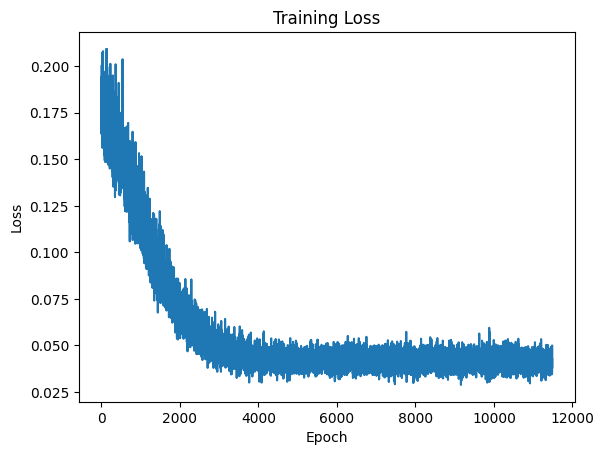

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
from model import MLPColorPredictor, PositionEncodingMLP
from predict import save_predicted_image, process_in_batches
import os
from tqdm import tqdm
from config import *
import torch
from numba import cuda


torch.cuda.init()
torch.cuda.reset_peak_memory_stats(device=None)  # 모든 디바이스에 대해 메모리 통계 재설정


def save_weights(model, epoch, image, method, folder="weights"):
    if not os.path.exists(folder):
        os.makedirs(folder)
    path = os.path.join(folder, f"model_{image}_{method}_{epoch}.pth")
    torch.save(model.state_dict(), path)
    print(f"Model weights saved to {path}")


class CustomDataset(Dataset):
    def __init__(self, xy_coords, colors):
        self.xy_coords = torch.tensor(xy_coords, dtype=torch.float32)
        self.colors = torch.tensor(colors, dtype=torch.float32)

    def __len__(self):
        return len(self.xy_coords)

    def __getitem__(self, idx):
        return self.xy_coords[idx], self.colors[idx]


# Dataset을 생성하고 DataLoader로 배치 및 셔플 설정
def create_dataloader(xy_coords, colors, batch_size, shuffle=True):
    dataset = CustomDataset(xy_coords, colors)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader


# 1. Load image and create (x, y) -> RGB dataset
def load_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
    height, width, _ = img.shape
    print("height, width", height, width)
    # Create (x, y) and RGB datasets
    xy_coords = []
    colors = []

    for y in range(height):
        for x in range(width):
            xy_coords.append([x / width, y / height])  # Normalize (x, y) to [0, 1]
            # xy_coords.append([x,y])
            colors.append(img[y, x])  # RGB color at (x, y)

    return np.array(xy_coords), np.array(colors)


# 2. Create batch dataset for training
def create_batch(xy_coords, colors, batch_size):
    indices = random.sample(range(len(xy_coords)), batch_size)
    xy_batch = torch.tensor(xy_coords[indices], dtype=torch.float32)
    color_batch = torch.tensor(colors[indices], dtype=torch.float32)
    return xy_batch, color_batch


# 3. Training loop
def train_model(
    model, dataloader, xy_coords, colors, num_epochs=1000, batch_size=1024, lr=1e-4
):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()  # Mean Squared Error loss for RGB color prediction
    losses = []
    for epoch in range(num_epochs):
        for step, batch in enumerate(dataloader):
            # Create a random batch
            xy_batch, color_batch = batch
            xy_batch=xy_batch.to("cuda")
            color_batch=color_batch.to("cuda")
            # Forward pass
            optimizer.zero_grad()
            predictions = model(xy_batch)
            # print("Pred :", predictions.shape)

            # Compute loss
            loss = criterion(predictions.float(), color_batch.float())
            # print(loss.dtype)
            losses.append(loss.item())

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            if (step + 1) % 100 == 0:
                print(
                    f"epoch: {epoch +1}/{EPOCH} step [{step+1}/{len(dataloader)}], Loss: {loss.item():.4f}"
                )

    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.savefig("loss_graph_{METHOD}.png")  # Save the plot as an image file
    print("start predictions")

    # Create (x, y) grid for prediction
    xy_coords = []
    for y in range(HEIGHT):
        for x in range(WIDTH):
            xy_coords.append([x / WIDTH, y / HEIGHT])  # Normalize (x, y) to [0, 1]
            # xy_coords.append([x,y])

    xy_coords = torch.tensor(xy_coords, dtype=torch.float32)
    print("proccessed batches")
    predictions = process_in_batches(xy_coords, model, batch_size=1024)
    predictions = predictions.detach().numpy()

    # Reshape predictions to image format
    predicted_img = predictions.reshape((HEIGHT, WIDTH, 3))  # (H, W, 3)

    # Convert to image format and save
    predicted_img = (predicted_img * 255).astype(np.uint8)  # Convert to uint8 [0, 255]
    img = Image.fromarray(predicted_img)
    output_path = os.path.join("results", f"predicted_{IMAGE_PATH}_{METHOD}.png")
    img.save(output_path)
    print(f"Predicted image saved to {output_path}")


# Example usage

xy_coords, colors = load_image(IMAGE_PATH)
dataloader = create_dataloader(
    xy_coords=xy_coords, colors=colors, batch_size=BATCH_SIZE, shuffle=True
)
# Initialize model
if METHOD == "position":
    model = PositionEncodingMLP()
elif METHOD == "quantum":
    model = sin_qml(10, 4, False).to('cuda:0')
else:
    model = MLPColorPredictor()

# Train model
train_model(
    model,
    dataloader,
    xy_coords,
    colors,
    num_epochs=EPOCH,
    batch_size=BATCH_SIZE,
    lr=LR,
)


# save_weights(model, epoch=10, image=image_path, method=method)


In [39]:

def process_in_batches(
    xy_coords,
    model,
    batch_size=64,
):
    # 입력 데이터를 텐서로 변환xw
    # 모델을 사용할 장치로 이동 (MPS는 Mac에서 Metal 가속 장치)

    # 모델 예측을 저장할 리스트
    all_predictions = []

    # 데이터를 batch 단위로 나누어 처리
    # The `with torch.no_grad():` statement is a context manager provided by PyTorch
    # that temporarily sets all the `requires_grad` flags to `False`. This means that
    # any operations inside this context block will not build the computational graph
    # for gradient computation. It is commonly used during inference or evaluation to
    # disable gradient calculation, which can help reduce memory consumption and speed
    # up computations since no gradients need to be calculated or stored.
    with torch.no_grad():
        for i in tqdm(range(0, len(xy_coords), batch_size)):
            batch_coords = xy_coords[i : i + batch_size]
            # 모델을 사용하여 예측
            predictions = model(torch.tensor(batch_coords).cuda())
            predictions = predictions.detach()
            # 결과를 리스트에 저장
            all_predictions.append(predictions)  # GPU/MPS에서 CPU로 이동

    # 모든 배치를 합쳐서 하나의 텐서로 반환
    return torch.cat(all_predictions, dim=0)


# 3. 예측된 이미지를 result 폴더에 저장하는 함수
def save_predicted_image(model, width, height, image, method, output_folder="results"):
    print("start predictions")
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Create (x, y) grid for prediction
    xy_coords = []
    for y in range(height):
        for x in range(width):
            xy_coords.append([x / width, y / height])  # Normalize (x, y) to [0, 1]
            # xy_coords.append([x,y])

    xy_coords = torch.tensor(xy_coords, dtype=torch.float32)
    xy_coords.to('cuda')
    # xy_coords = xy_coords.to("mps")
    # Predict RGB values for each (x, y) coordinate
    # with torch.no_grad():
    # model.to("mps")
    print("proccessed batches")
    predictions = process_in_batches(xy_coords, model, batch_size=64)
    predictions = predictions.detach().numpy()

    # Reshape predictions to image format
    predicted_img = predictions.reshape((height, width, 3))  # (H, W, 3)

    # Convert to image format and save
    predicted_img = (predicted_img * 255).astype(np.uint8)  # Convert to uint8 [0, 255]
    img = Image.fromarray(predicted_img)
    output_path = os.path.join(output_folder, f"predicted_{image}_{method}.png")
    img.save(output_path)
    print(f"Predicted image saved to {output_path}")

In [42]:
    # predictions = process_in_batches(xy_coords, model, batch_size=1024)
    predictions = predictions.cpu().detach().numpy()

    # Reshape predictions to image format
    predicted_img = predictions.reshape((HEIGHT, WIDTH, 3))  # (H, W, 3)

    # Convert to image format and save
    predicted_img = (predicted_img * 255).astype(np.uint8)  # Convert to uint8 [0, 255]
    img = Image.fromarray(predicted_img)
    output_path = os.path.join("results", f"predicted_{IMAGE_PATH}_{METHOD}.png")
    img.save(output_path)
    print(f"Predicted image saved to {output_path}")

Predicted image saved to results/predicted_test3.jpg_quantum.png


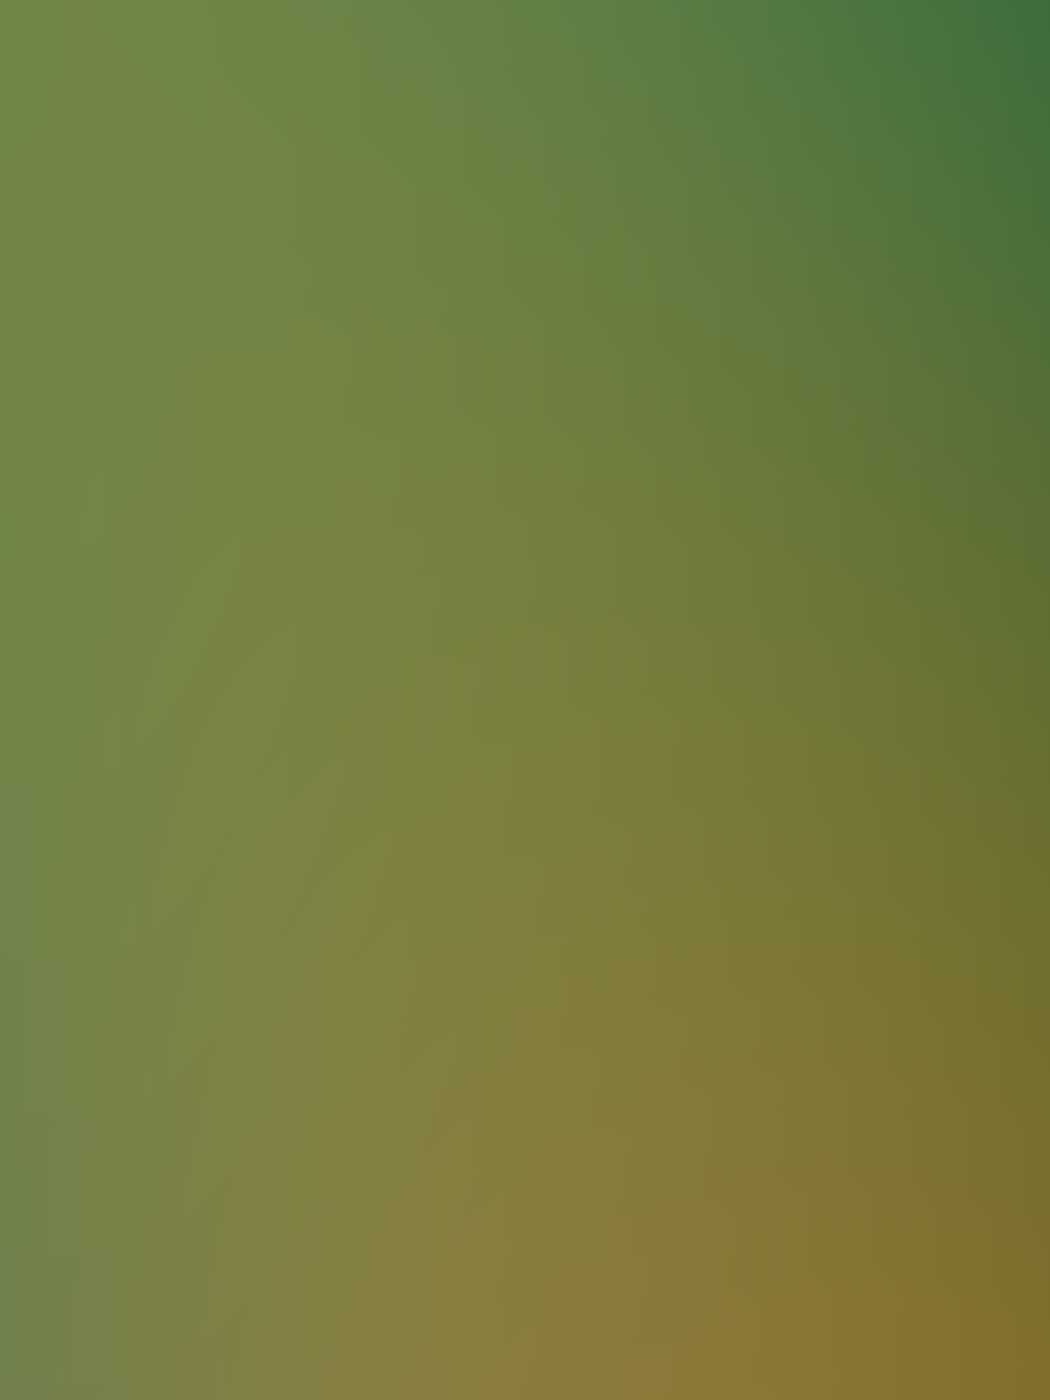

In [45]:
img